In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ipynb_path
from glasbey import create_palette
import napari

In [2]:
# add location of spots directory
spots_directory = None

if not spots_directory:
    # look for spots directory using path to this notebook
    spots_directory = Path(ipynb_path.get()).parent.parent / "data/spots"

spots_directory = Path(spots_directory)

print("".join(f"{f.name} \n" for f in spots_directory.glob("*_spots.csv")))

spots_df = pd.read_csv(list(spots_directory.glob("*_spots.csv"))[3])

print(spots_df.columns)

spots_df = spots_df.set_index("index")

lightsheet_20241104_spots.csv 
lightsheet_20250131_spots.csv 
lightsheet_20250206_spots.csv 
lightsheet_20250414_spots.csv 

Index(['index', 'time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area',
       'radius', 'intensity_mean', 'cycle', 'display_z', 'display_y',
       'display_x', 'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id'],
      dtype='object')


In [3]:
len(spots_df[spots_df["time_since_nc11"] == -5])

347

In [4]:
import networkx as nx

In [5]:
# spots_df = spots_df.set_index("index")

graph = nx.DiGraph()

ss = spots_df[spots_df["parent_id"] != -1]
pairs = list(zip(ss["parent_id"], ss.index))

graph.add_edges_from(pairs)

# dt = spots_df["parent_id"].map(spots_df["time"]) - spots_df["time"]
#
# print(dt.describe())
#
# sns.histplot(x=dt)
# plt.show()

448839


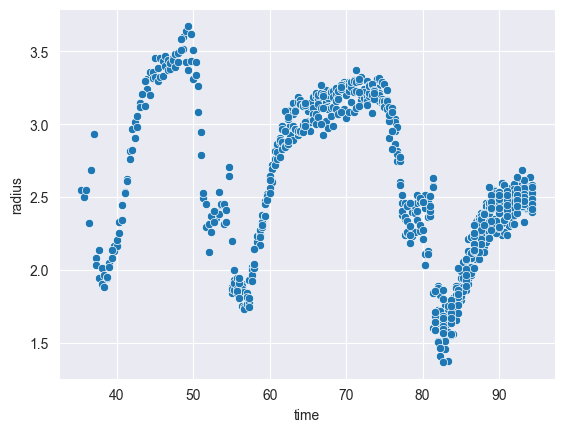

In [6]:
print(list(graph.nodes)[50000])

sns.scatterplot(spots_df.loc[list(nx.descendants(graph, 448839))], x="time", y="radius")
plt.show()

In [7]:
# take a mid NC13 timepoint

# tp = spots_df[spots_df["cycle"] == 13]["frame"].median()

tp = spots_df["frame"].max()
ss = spots_df[spots_df["frame"] == tp].copy()

viewer = napari.Viewer()

X = ss[["z", "y", "x"]].values

pal = create_palette(200)
color = [pal[tid % 200] for tid in ss["track_id"].values]

viewer.add_points(X, face_color=color, size=2*ss["radius"])

napari.run()

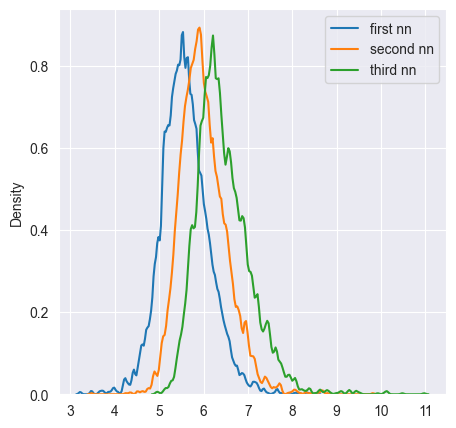

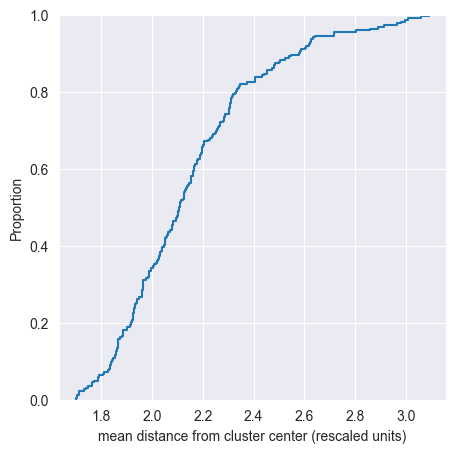

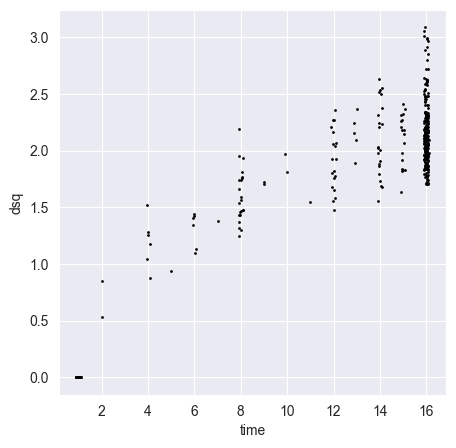

In [8]:
from scipy.spatial.distance import cdist


def calculate_unit_spread(frame_df, trackid ="track_id"):

    frame_df = frame_df.copy()

    spatial_axes = ["z", "y", "x"]

    group_size = frame_df.groupby(trackid)["time"].count()
    group_centers = frame_df.groupby(trackid)[spatial_axes].mean()

    positions = frame_df[["z", "y", "x"]].values

    distance_matrix = cdist(positions, positions)
    np.fill_diagonal(distance_matrix, 100)

    # create a unit based on the average distance to a nucleus' nearest neighbor
    dm_rescale = np.mean(np.min(distance_matrix, axis=0))

    tot = frame_df["x"] * 0

    for col in spatial_axes:
        dc = ((frame_df[col] - frame_df[trackid].map(group_centers[col])) / dm_rescale)**2
        tot += dc

    frame_df["dsq"] = tot

    sd = np.sqrt(frame_df.groupby(trackid)["dsq"].sum() / (frame_df.groupby(trackid)["dsq"].count()))

    return group_size, sd

def get_nn_distances(df):

    positions = df[["z", "y", "x"]].values

    distance_matrix = cdist(positions, positions)
    np.fill_diagonal(distance_matrix, 100)

    distance_matrix = np.sort(distance_matrix, axis=0)

    return distance_matrix[0], distance_matrix[1], distance_matrix[2]

"""
Plot nearest neighbor distance distribution
"""

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nn1, nn2, nn3 = get_nn_distances(ss)

sns.kdeplot(x=nn1, bw_adjust=0.3, label = "first nn")
sns.kdeplot(x=nn2, bw_adjust=0.3, label = "second nn")
sns.kdeplot(x=nn3, bw_adjust=0.3, label = "third nn")

plt.legend()
plt.show()

"""
Plot normalized lineage spread
"""
x, sd = calculate_unit_spread(ss, "track_id")

# ecdf plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.ecdfplot(x=sd[x==16])
plt.xlabel("mean distance from cluster center (rescaled units)")
plt.show()

# stripplot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.stripplot(x=x, y=sd, color="k", s=2, native_scale=True)
plt.show()


# frame_df["sd"] = frame_df["track_id"].map(sd)

# pal = sns.color_palette("crest", as_cmap=True)
# pal = sns.color_palette("viridis", as_cmap=True)
#
# color = pal(ss["nn1"] / np.max(ss["nn1"]))
#
# viewer = napari.Viewer()
# viewer.add_points(X, face_color=color, size=2*ss["radius"])
#
# napari.run()

# y = ss.groupby("track_id")["dsq"].mean()
#
# sns.stripplot(x=x, y=sd, color="k", s=2)

In [9]:
from scipy.spatial.distance import cdist
from random import sample, shuffle

def generate_adjacency_graph(df):

    axes = ["z", "y", "x"]
    positions = df[axes].values
    dm = cdist(positions, positions)
    np.fill_diagonal(dm, 100)

    # calculate neighbors as being no more than 50% farther than the nearest neighbor
    sorted_dm = np.sort(dm, axis=0)
    indices = np.argwhere(dm < sorted_dm[0] * 1.5)

    # make edges from thresholded distance matrix
    mapping = {i: kk for i, kk in enumerate(df.index)}
    wheres = [(mapping[a[0]], mapping[a[1]]) for a in indices]

    new_graph = nx.Graph()
    new_graph.add_edges_from(wheres)

    return new_graph

def n_descendants(tree, tree_root):
    """
    Finds the number of descendants of every node in the tree, given the root
    """
    descendants = {}

    def postorder(n):
        count = 0
        for child in tree.successors(n):
            count += 1 + postorder(child)
        descendants[n] = count
        return count

    postorder(tree_root)

    return descendants

def make_random_regrouping(df, adjacency_graph):

    for e in adjacency_graph.edges():
        adjacency_graph[e[0]][e[1]]["weight"] = np.random.uniform(0.99, 1.01)


    root = sample(list(adjacency_graph.nodes), 1)[0]

    st = nx.minimum_spanning_tree(adjacency_graph)
    st = nx.bfs_tree(st, root)

    targets = list(df.groupby("track_id")["track_id"].count())

    subgraphs = []
    complete = False
    while not complete:

        t = sample(targets, 1)[0]

        searching = True
        t_base = t
        delta = 0

        delta_order = [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8]
        delta_index = 0
        delta_order = delta_order * sample([-1, 1], 1)[0]

        while searching:

            if len(st) <= t:
                subgraphs.append(st)
                complete = True
                break

            for n, k in n_descendants(st, root).items():

                # find branch of desired length in the tree
                if k == t - 1:
                    parent = list(st.predecessors(n))[0]

                    # trim the edge to the parent
                    st.remove_edge(parent, n)

                    # take the trimmed subgraph
                    subgraph = nx.bfs_tree(st, n)
                    subgraphs.append(subgraph)
                    searching = False

                    # rebuild the tree from the root
                    st = nx.bfs_tree(st, root)

                    break

            if not searching:
                break

            if delta_index == len(delta_order):
                break

            delta = delta_order[delta_index]
            delta_index += 1

            t = t_base + delta

            if t <= 0:
                break

    print(len(targets))
    print(len(subgraphs))

    tid_map = {}

    for j, s in enumerate(subgraphs):

        for node in s:
            tid_map[node] = j

    return subgraphs, tid_map


372
413


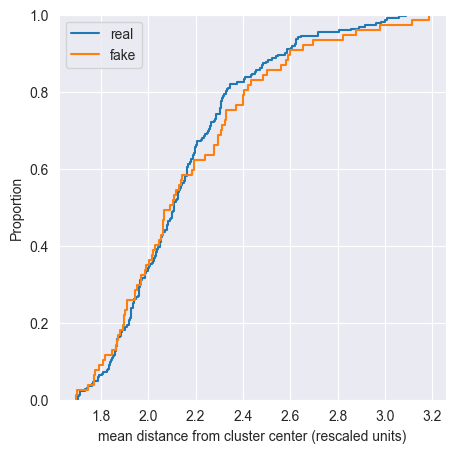

In [11]:

graph = generate_adjacency_graph(ss)
subgraphs, tid_map = make_random_regrouping(ss, graph)

ss['fake_track_id'] = ss.index.map(tid_map)

"""
Compare ECDF between real and fake lineages
"""
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x, sd = calculate_unit_spread(ss, "track_id")
sns.ecdfplot(x=sd[x==16], label="real")

x, sd = calculate_unit_spread(ss, "fake_track_id")
sns.ecdfplot(x=sd[x==16], label="fake")

plt.xlabel("mean distance from cluster center (rescaled units)")

plt.legend()

plt.show()

viewer = napari.Viewer()

X = ss[["z", "y", "x"]].values

pal = create_palette(200)

color = []

for tid in ss["fake_track_id"].values:

    if not np.isnan(tid):
        color.append(pal[int(tid) % 200])

    else:
        color.append("#000000")

color2 = [pal[tid % 200] for tid in ss["track_id"].values]

viewer.add_points(X, face_color=color, size=2*ss["radius"], name="fake")
viewer.add_points(X, face_color=color2, size=2*ss["radius"], name="real")

napari.run()